# Benchmark of intronic variation impacting RNA Splicing

This notebook refers to a comprehensive analysis of the prediction tools performance on variants that affect RNA Splicing. We spent a great ammount of time gathering and curating a dataset of pathogenic intronic variation located outside of canonical splice sites. Additionally, we carefully collected non-redundant variants from multiple recent studies that were shown to affect splicing outcome. Particularly, we were able to generate valuable subsets of variants that affect splicing differently (e.g. creating cryptic splice sites, affecting splicing regulatory elements, strenghning of existing cryptic sites, branchpoint disruption, etc). 

 After dataset collecion and running of the tools (most of them annotated using existing pre-computed scores), most of the analysis were performed with [VETA](https://github.com/PedroBarbosa/VETA), a simple standalone tool designed to benchmark prediction tools from VCF files. VETA's single requirement is that it just accepts VCFs annotated with [Ensembl VEP](https://www.ensembl.org/info/docs/tools/vep/script/index.html), because the `CSQ` INFO field is used to extract additional information about the variants being evaluated. 

In [ ]:
! pip install wand

In [5]:

import os
from wand.image import Image as WImage

os.makedirs("out", exist_ok=True)

## **Clinvar v202204**

### *Data processing*

After annotating Clinvar with Ensembl VEP (Consequences in `CSQ` field automatically picked and filtered with `--per_gene --pick_order ccds,canonical,biotype,rank --no_intergenic --gencode_basic'`), we selected SNVs with any `intronic` consequence ocurring in protein coding genes and with Pathogenic/Likely pathogenic or Benign/Likely benign classifications. From there, we filtered those variants that are also exonic in any other transcript structure, so that at the end we keep only variants that are unequivocally intronic.

In [2]:
# Variants with any intronic consequence
#! bcftools view -v snps clinvar_annotated.vcf.gz | filter_vep --only_matched --filter '(BIOTYPE is protein_coding and HGVSc and INTRON) and (CLNSIG is Pathogenic or CLNSIG is Likely_pathogenic or CLNSIG is Pathogenic/Likely_pathogenic or CLNSIG is Benign or CLNSIG is Likely_benign or CLNSIG is Benign/Likely_benign)' | bgzip > clinvar_any_intronic_conseq_snvs.vcf.gz

# From any intronic, get those that have any exonic consequence and remove those
#! bcftools isec isec_to_get_exonic -p isec_to_get_exonic clinvar_annotated.vcf.gz clinvar_any_intronic_conseq_snvs.vcf.gz 
#! cat isec_to_get_exonic/0002.vcf | filter_vep --only_matched --filter 'EXON' | bgzip > any_exonic.vcf.gz
#! bcftools isec -p to_get_non_exonic clinvar_any_intronic_conseq_snvs.vcf.gz any_exonic.vcf.gz && mv to_get_non_exonic/0000.vcf to_get_non_exonic/non_exonic.vcf && bgzip to_get_non_exonic/non_exonic.vcf

# Non_exonic still contains many 'downstream_gene_variant', 'upstream_gene_variant', 'TF_binding_site_variant' and 'regulatory_region_variant'.
# filter_vep --only_matched --filter 'Consequence is TF_binding_site_variant or Consequence is regulatory_region_variant or Consequence is upstream_gene_variant or Consequence is downstream_gene_variant' --input to_get_non_exonic/non_exonic.vcf.gz | bgzip > no_gene_body.vcf.gz
# filter_vep --only_matched --filter 'Consequence != TF_binding_site_variant and Consequence != regulatory_region_variant and Consequence != upstream_gene_variant and Consequence != downstream_gene_variant' --input to_get_non_exonic/non_exonic.vcf.gz | bgzip > in_gene_body.vcf.gz

# From the no_gene_body set, select only those variants that are annotated in Clinvar (MC) with intronic ontology terms (filter_vep and bcftools filter had issues filtering this field)
#! zcat no_gene_body.vcf.gz | grep -v "^#" | grep -w -e 'MC=SO:0001574|splice_acceptor_variant' -e 'MC=SO:0001627|intron_variant' -e 'MC=SO:0001575|splice_donor_variant' | grep -v -e "SO:0001583|missense_variant" -e "SO:0001819|synonymous_variant" -e "SO:0001587|nonsense" -e "SO:0001582|initiatior_codon_variant" -e "SO:0001578|stop_lost" > no_gene_body_intronic_in_MC_field.vcf
# bcftools view -h no_gene_body.vcf.gz > h && cat h no_gene_body_intronic_in_MC_field.vcf | bgzip > no_gene_body_intronic_in_MC_field.vcf.gz && rm no_gene_body_intronic_in_MC_field.vcf

# From the in_gene_body set, we will remove those that have no_gene_body consequences
# bcftools isec -p in_gene_body_only in_gene_body.vcf.gz no_gene_body_intronic_in_MC_field.vcf.gz && mv in_gene_body_only/0000.vcf in_gene_body_only/in_gene_body_only.vcf

# From the no_gene_body intronic set that , we will select the pathogenic variant or those with any splice-related consequence . 
# filter_vep --input in_gene_body_only/0002.vcf --filter 'CLNSIG match athogenic or Consequence matches splice' | bgzip > no_gene_body_intronic_splicing.vcf.gz

# Variant to join to get the final set
# in_gene_body_only.vcf.gz - Variants occurring inequivocally in introns (outside gene body and variants with exon consequences are out)
# no_gene_body_intronic_splicing.vcf.gz - Pathogenic variants and splice-related variants (including benign) that were annotated with consequences outside of gene body (besides intronic ones) and that have intronic-associated MC field in original Clinvar 
# ! bcftools concat -a in_gene_body_only.vcf.gz no_gene_body_intronic_splicing.vcf.gz | bcftools norm -d none | bgzip > to_keep.vcf.gz
# filter_vep --only_matched --filter '(BIOTYPE is protein_coding and HGVSc and INTRON)' --input to_keep.vcf.gz | bgzip > clinvar_intronic_snvs.vcf.gz


Given the disproportionally large number of benign vs pathogenic variants (109,605 vs 22,005 respectively), we additionally filtered benign variants so that all high-quality benign/likely benign variants were kept, by selecting records with two or more stars. The output of this step kept 13,093 variants.

In [3]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter '(CLNSIG match enign) and (CLNREVSTAT is criteria_provided,_multiple_submitters,_no_conflicts or CLNREVSTAT is reviewed_by_expert_panel or CLNREVSTAT is practice_guideline)' | bgzip > clinvar_benign_2s.vcf.gz

To avoid being to conservative (right now benign set (N=13,093) was actually smaller than the pathogenic one (N=22,005)), we selected variants with 1 star and `Benign` classifications (N=46,166). To avoid the dataset to be excessively unbalanced we randomly selected 36,907 variants, which summed up to the high-confident 2 star set (N=13,093) ammounts to exactly 50k variants. This final number of benign variants approximately doubles the size of the pathogenic one. 

In [4]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter '(CLNSIG is Benign) and (CLNREVSTAT is criteria_provided,_single_submitter)' | bgzip > clinvar_benign_1s.vcf.gz
#! zcat clinvar_benign_1s.vcf.gz | grep -v "^#" | shuf -n 36907 | bgzip > clinvar_benign_1s_subset.vcf.gz
#! zcat clinvar_benign_2s.vcf.gz clinvar_benign_1s_subset.vcf.gz | bcftools sort -Oz -o clinvar_benign_50k.vcf.gz && tabix -pvcf clinvar_benign_50k.vcf.gz

We now select all the pathogenic variants (N=22,005) and concatenate them with the benign set (N=50,000), so that this new Clinvar intronic dataset can be evaluated by VETA (N=72,005). 

In [5]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter 'CLNSIG match athogenic' | bgzip > clinvar_pathogenic.vcf.gz && tabix -pvcf clinvar_pathogenic.vcf.gz
#! bcftools concat -a clinvar_benign_50k.vcf.gz clinvar_pathogenic.vcf.gz | bcftools sort | bgzip > clinvar_to_VETA_evaluation.vcf.gz && tabix -pvcf clinvar_to_VETA_evaluation.vcf.gz

### *VETA evaluation*

After using a combination of attributes to filter benign variants according to the Clinvar review status, we generated a final single dataset with variants from both labels (benign, pathogenic). We will run VETA by filtering for variants with more than 1 star (`--clinvar_stars 1s_l`), so that only Pathogenic variants with any criteria provided are kept (remember that before we did not filter the Pathogenic variants by its review status). We will additionally set `--do_intronic_analysis` to perform the evaluations using a bin-based approach. Given that the datasets per bin are largely unbalanced (much more benign variants at all bins except at splice site locations), we will use the `weighted_F1` metric to score the tools

First, we run VETA on each group of tools separately (`Splicing`, `Whole_genome`, `Conservation`): 

* ### Splicing tools

In [1]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_splicing \
    --scopes_to_evaluate Splicing \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz &> out/log_clinvar_splicing.txt 

The distribution of variants on each intronic bin is highly uneven 

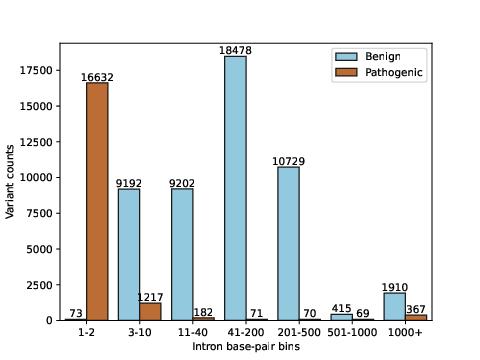

In [6]:
counts="/Users/pbarbosa/git_repos/paper_intronic_benchmark/out/out_clinvar_splicing/1s_l/intron_analysis/variant_counts/counts_per_intronic_bin_all.pdf"
img = WImage(filename=counts, resolution=75)
img

Performance drops significantly right after splice site positions, specially in donor-associated variants

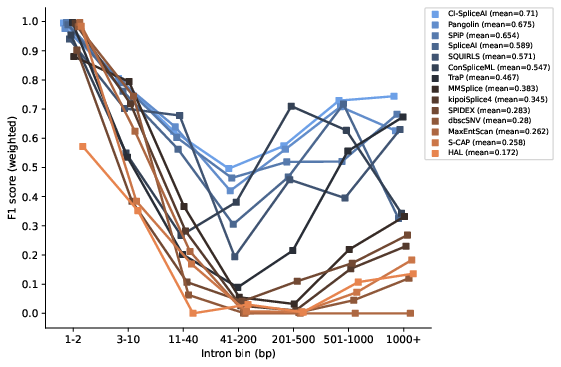

In [20]:
perf="/Users/pbarbosa/git_repos/paper_intronic_benchmark/out/out_clinvar_splicing/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

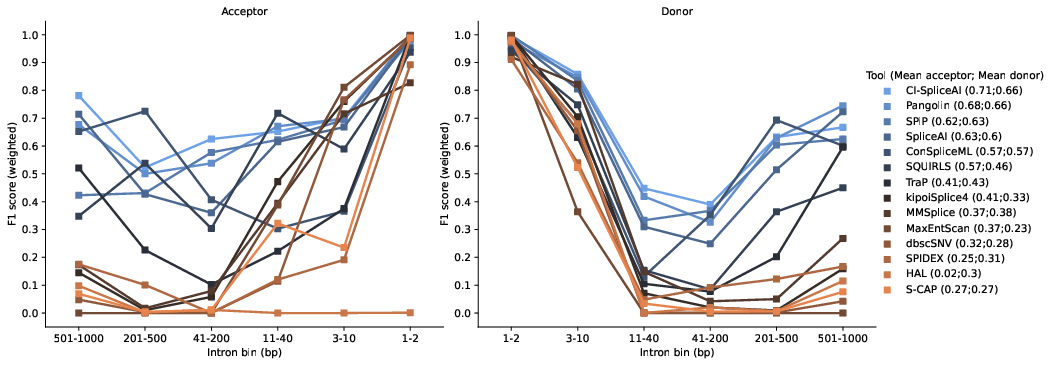

In [7]:
perf_per_bin="/Users/pbarbosa/git_repos/paper_intronic_benchmark/out/out_clinvar_splicing/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

* ### Conservation scores

As for the Splicing tools, perfomance drops significantly after the two dinucleotides. However, there's a slight increase at deeper intronic space.

In [8]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_conservation \
    --scopes_to_evaluate Conservation \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz &> out/log_clinvar_conservation.txt 

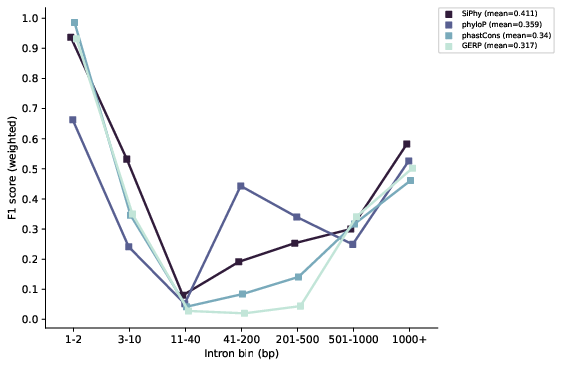

In [19]:
perf="out/out_clinvar_conservation/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

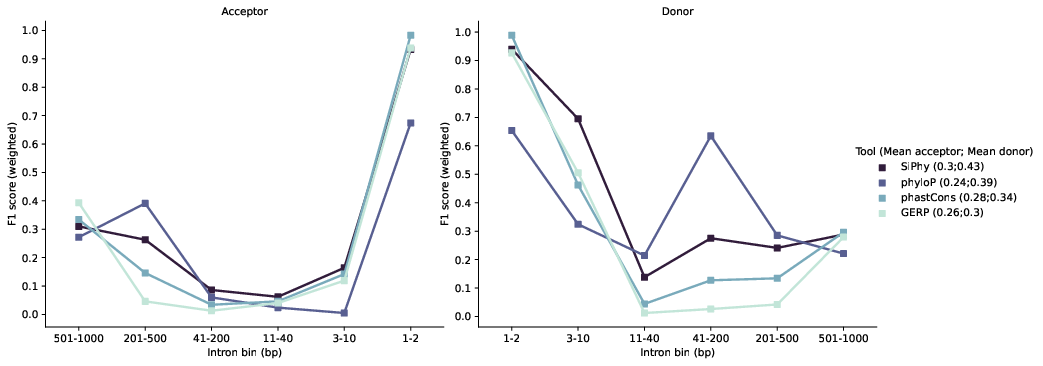

In [9]:
perf_per_bin="out/out_clinvar_conservation/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

* ### Consequence agnostic predictors

In [10]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_whole_genome \
    --scopes_to_evaluate Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz &> out/log_clinvar_whole_genome.txt 

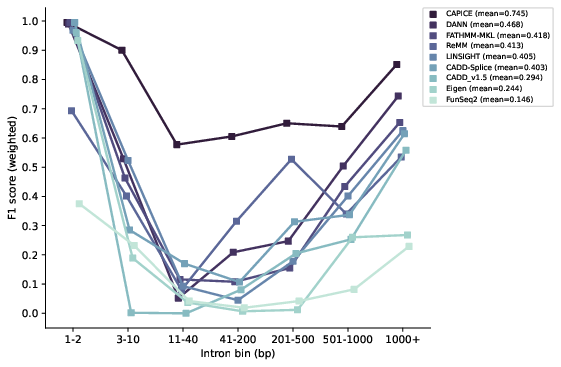

In [18]:
perf="out/out_clinvar_whole_genome/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

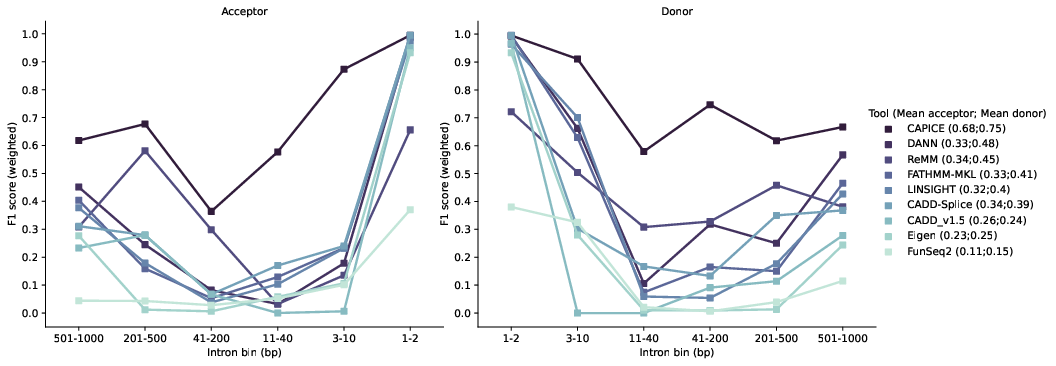

In [11]:
perf_per_bin="out/out_clinvar_whole_genome/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

CAPICE stood out with a weighted F1 score mean of > 0.7 across bins. Since training variants of this model (as well as CADD and DANN) are available, we wanted to control for type I circularity issues. Hence, we excluded variants from our evaluation dataset that were used in the training of either CADD/DANN/CADD-Splice or CAPICE. This lead to a exclusion of 15,789 variants from the clinvar intronic dataset. Thus, we performed again the evaluation of consequence-agnostic predictors using 56,216 variants. Since we set the filtering strategy to `1s_l`, some 0 star pathogenic variants were also excluded (N=3359) during the VETA run. Total number of intronic variants evaluated equals to 52857.

In [12]:
! rm data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_whole_genome_circularity \
    --scopes_to_evaluate Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz &> out/log_clinvar_whole_genome_circularity.txt 

rm: data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz.tsv: No such file or directory


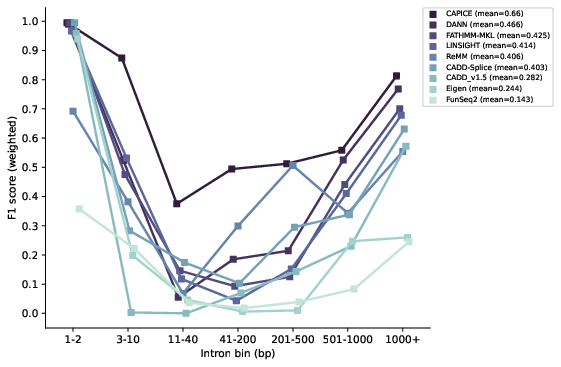

In [17]:
perf_per_bin="out/out_clinvar_whole_genome_circularity/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

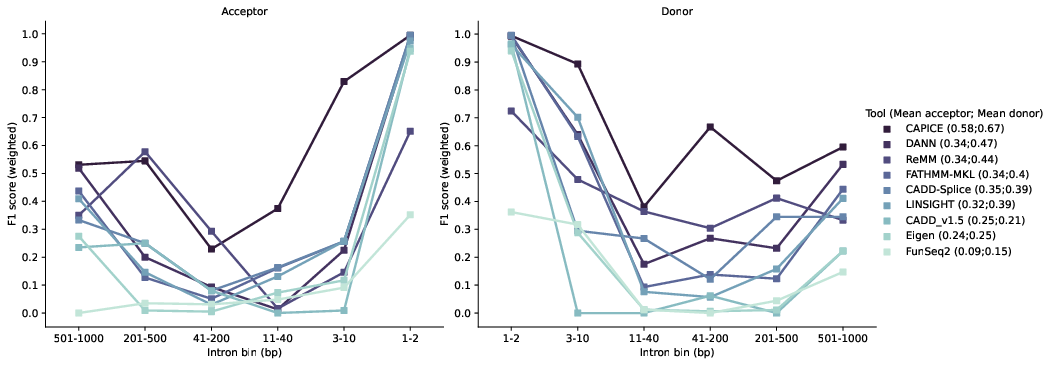

In [13]:
perf_per_bin="out/out_clinvar_whole_genome_circularity/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

 * ### All tools together for specific analysis

In [14]:
! rm data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_all \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    data/clinvar/circularity/clinvar_circularity_resilient.vcf.gz &> out/log_clinvar_all.txt

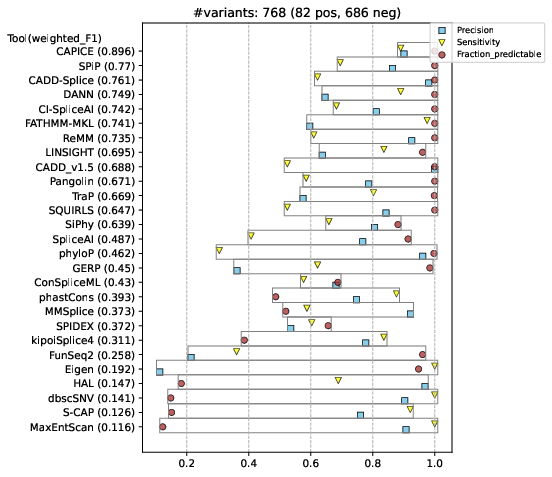

In [21]:
utr5="out/out_clinvar_all/1s_l/tools_benchmark/snps/performance_at_fixed_thresh/scatter_snps_5primeUTR.pdf"
img = WImage(filename=utr5, resolution=75)
img

 * ### Performance tends to increase slightly at the 1000+bp bin. How does the performance change after excluding variants that are either exonic or intronic with a smaller offset in other transcripts of the same gene ?

In [217]:
! rm data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv
! veta benchmark --out_dir out/out_clinvar_excluding_some_plus_1000 \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --do_intronic_analysis \
    data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz &> out/log_clinvar_excluding_some_1000bp.txt

rm: data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv: No such file or directory


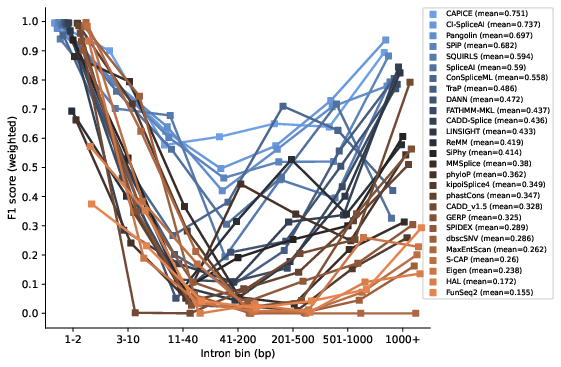

In [218]:
perf="out/out_clinvar_excluding_some_plus_1000/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

In [220]:
! rm data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv
! veta benchmark --out_dir out/TEST_exonic \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    data/clinvar/plus_1000/exonic.vcf &> out/log_TEST_exonic.txt

In [221]:
! rm data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv
! veta benchmark --out_dir out/TEST_1_conseq \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    data/clinvar/plus_1000/one_conseq.vcf &> out/log_TEST_one_conseq.txt

rm: data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv: No such file or directory


In [224]:
! rm data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv
! veta benchmark --out_dir out/TEST_more_1_conseq_same_offset \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    data/clinvar/plus_1000/more_1_conseq_same_offset.vcf &> out/log_TEST_more_1_conseq_same_offset.txt

rm: data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv: No such file or directory


In [222]:
! rm data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv
! veta benchmark --out_dir out/TEST_more_1_conseq_shorter_offset_higher_1000 \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    data/clinvar/plus_1000/more_1_conseq_shorter_offset_higher_1000.vcf &> out/log_more_1_conseq_shorter_offset_higher_1000.txt

rm: data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv: No such file or directory


In [223]:
! rm data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv
! veta benchmark --out_dir out/TEST_more_1_conseq_shorter_offset_lower_1000 \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    data/clinvar/plus_1000/more_1_conseq_shorter_offset_lower_1000.vcf &> out/log_more_1_conseq_shorter_offset_lower_1000.txt

rm: data/clinvar/plus_1000/clinvar_excluding_some_1000bp_plus.vcf.gz.tsv: No such file or directory


## **Manually curated dataset of pathogenic intronic variation**

First, we will run a standard and faster benchmark without the `--do_intronic_analysis` flag. The goal is to see how all the tools behave overall, and test whether `Conservation` and `Whole_genome` (not splicing-specific) can be excluded from further analysis, since from now on all the variants evaluated are related with splicing aberrations.

Results show that most of these Conservation and Consequence-agnostic tools can be excluded (< 0.7), except for CADD-Splice. 

In [ ]:
from wand.image import Image as WImage

In [226]:
! veta benchmark --out_dir out/out_manual_curation_all_tools \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/clinvar/tools_config.txt \
    data/manual_curation  &> out/log_manual_curation_all_tools.txt 

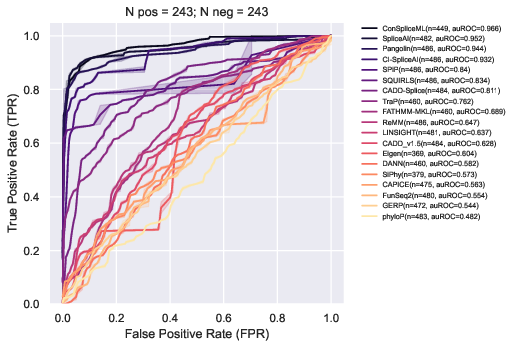

In [25]:
overall_perf="out/out_manual_curation_all_tools/tools_benchmark/all_types/roc_analysis/ROC_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

Now, we run VETA for the selected tools and activate the `--do_threshold` and `--bootstrap` flag. We want to study how fit are the reference thresholds for deep intronic splicing-related variants. Clearly, some reference thresholds are not appropriate for distinguishing deep intronic pathogenic vs benign variants.

In [225]:
! veta benchmark --out_dir out/out_manual_curation_thesholds \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/manual_curation/tools_config.txt \
    --do_threshold_analysis \
    --bootstrapping \
    data/manual_curation &> out/log_manual_curation_thresh.txt 

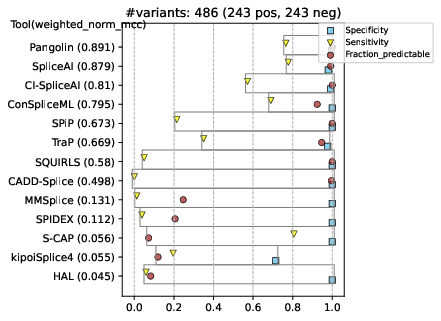

In [27]:
overall_perf="out/out_manual_curation_thesholds/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

By running again a standard analysis using the new, adjusted thresholds, performance increases snicely.

In [33]:
! cp out/out_manual_curation_thesholds/thresholds_analysis/new_configs/new_config_intronic_f0.5.txt data/manual_curation/
! cp out/out_manual_curation_thesholds/thresholds_analysis/new_configs/new_config_intronic_f1.txt data/manual_curation/
! cp out/out_manual_curation_thesholds/thresholds_analysis/new_configs/new_config_intronic_f1.5.txt data/manual_curation/
! veta benchmark --out_dir out/out_manual_curation_adjusted_thesh \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/manual_curation/new_config_intronic_f1.txt \
    --do_intronic_analysis \
    data/manual_curation  &> out/log_manual_curation_adjusted_thresh.txt 

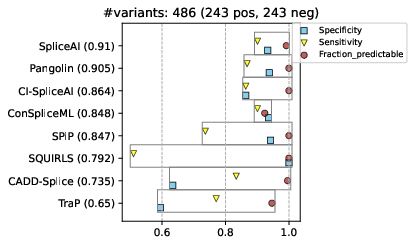

In [34]:
overall_perf="out/out_manual_curation_adjusted_thesh/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

## **Pseudoexon activation vs Exon enlongation**

In [249]:
! veta benchmark --out_dir out/out_manual_curation_pseudoexon_only \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/manual_curation/new_config_intronic_f1.txt data/manual_curation/pe_activation &> out/log_manual_curation_pseudoexon_only.txt 
    #--config data/manual_curation/tools_config.txt  \

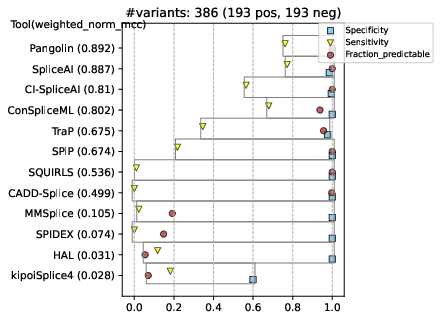

In [245]:
overall_perf="out/out_manual_curation_pseudoexon_only/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

In [250]:
! veta benchmark --out_dir out/out_manual_curation_exon_elongation_only \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/manual_curation/new_config_intronic_f1.txt \
    data/manual_curation/exon_elongation/ &> out/log_manual_curation_pe_elongation_only.txt 
    #--config data/manual_curation/tools_config.txt  \

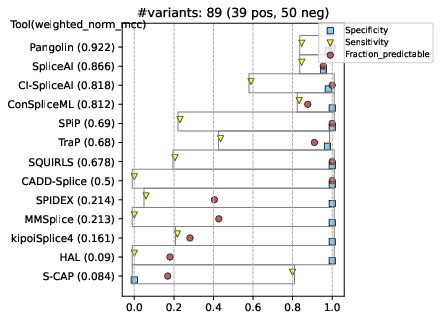

In [252]:
overall_perf="out/out_manual_curation_pe_elongation_only/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

# **Variants affecting RNA splicing**

This section of the analysis focuses on the comparison of prediction tools to identify splicing-altering variants that do so by different mechanisms. Some alter the branchpoint signal in the intron upstream, others create a new splice site that trigger pseudoexon inclusion, others activate existing cryptic splice sites that lead to exon elongation/partial intron retention. Several datasets were integrated and curated for this study:

* [VazDrago 2017](https://pubmed.ncbi.nlm.nih.gov/28497172/) and PedroBarbosa 2022 (N splicing altering=243): Our own curated list of disease-causing variants by means of alteration of RNA splicing. Used in the previous section, but here they are decomposed in different categories. 
* [Keegan 2022](https://pubmed.ncbi.nlm.nih.gov/35140743/) (N splicing altering=153): Comprehensive curation of variants that drive cryptic splicing, not all of them causing disease. Some overlap with our own curation, but many variants are unique. Large indels and coding variants were discarded. 
* [Petersen 2021](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24306) (N splicing altering=12): Comprehensive analysis of pseudoexon activation caused by intronic variants that do not create splice sites. Most of them create/repress/alter splicing regulatory elements within the generated pseudoexon. Many variants are already present in the two previous curation, hence the reduced final number of unique variants used.
* [Tubeuf 2020](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24091) (N splicing altering=3): Benchmark of user-friendly tools with variants that induce alterations in splicing regulatory elements. Most of variants collected are exonic, therefore we removed them. For a small set of intronic variants that induce pseudoexon activation (N=13), we selected 3 that are not present in any of the previous datasets collected.
* [Jung 2021](https://pubmed.ncbi.nlm.nih.gov/33420369/) (N splicing altering=252): Comprehensive caracterization of intronic mis-splicing in human cancers. They developed a method to caracterize intronic variation and its effect of splicing based on RNA-seq data. 
* [Moles-Fernández 2021](https://pubmed.ncbi.nlm.nih.gov/34283047/) (N splicing altering=19; N splicing neutral=99): Evaluation of the impact of splicing regulatory elements in the identification of variants in hereditary breast/ovarian cancer genes. Datasets collected from manual literature search as well as from other studies.
* [Adamson 2018](https://pubmed.ncbi.nlm.nih.gov/29859120/) (N splicing neutral=283): A MPRA (Vex-seq) to test the impact of 2059 variants in RNA-splicing spanning 110 alternative exons. Variants with no splicing effect (dPSI < 1) were selected, yielding a balanced number of exonic (to be compared with the splicing-altering variants ocurring within activated pseudoexons) and intronic variants.
* [Cheung 2019](https://pubmed.ncbi.nlm.nih.gov/30503770/) (N splicing neutral=109): Multiplexed functional assay (MFASS) that assayed the splicing effect of 27,733 variants from ExAC. Variants with no splicing effect (dPSI < 2 in both replicates) were selected. 
  
Here, we evaluate the performance of different methods on two broad classes (pseudoexon activation vs exon elongation), and then within each class we look at different splicing mechanisms. Because the number of branchpoint-related variants was small, we analyzed them into one separate class. Then, within each class we look at variants that activate donors, acceptors or affect splicing regulatory elements. 

To group variants from different studies into each splicing category, we run the R script `scripts/2_per_study_to_category.R` to generate the variant positions corresponding to each category. Then, the following commands were run to generate category-specific VCF files:

In [190]:
# #Branchpoint
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/branchpoint_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/branchpoint_associated/deleterious.vcf
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/branchpoint_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/branchpoint_associated/neutral.vcf

# # PE SRE
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/sre_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/sre_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/sre_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/sre_associated/neutral.vcf.gz

# # PE DONOR
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/new_donor/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/new_donor/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/new_donor/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/new_donor/neutral.vcf.gz

# # PE DONOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/donor_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/donor_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/donor_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/donor_associated/neutral.vcf.gz

# # PE ACCEPTOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/acceptor_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/acceptor_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/acceptor_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/acceptor_associated/neutral.vcf.gz

# # ELONG SRE
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/sre_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/sre_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/sre_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/sre_associated/neutral.vcf.gz

# # ELONG DONOR
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/new_donor/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/new_donor/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/new_donor/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/new_donor/neutral.vcf.gz

# # ELONG DONOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/donor_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/donor_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/donor_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/donor_associated/neutral.vcf.gz

# # ELONG ACCEPTOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/acceptor_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/acceptor_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/acceptor_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/acceptor_associated/neutral.vcf.gz

## **1) Branchpoint-associated variants**

This dataset is composed by 62 intronic variants that affect the branchpoint signal (located -18 to -44bp upstream of an annotated splicing acceptor), usually leading to intron retention and/or exon skipping. There are few exceptions that actually do the opposite, by creating a new branchpoint and leading to partial intron retention and/or pseudoexon activations. Variants from Jung (N=48), PedroBarbosa (N=9), Petersen (N=1), Moles-Fernandez (N=1) and Keegan (N=3) are included here. The neutral dataset (N=95) is composed of experimentally validated variants that between the -18 and -44 bp upstream of existing splicing acceptors, and did not lead to any splicing change. Variants from Adamson (N=59), Moles-Fernández (N=2) and Cheung (N=34) compose this neutral set.

For this analyis, we additionally incorporate branchpoint-specific tools such as BPP, labranchoR and SVM BP finder, as well as IntSplice2 that is targeted to make predictions in these regions. The steps to generate VCFs with the variant effect scores for BPP and SVM BP finder can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors). labranchoR was run within the kipoi framework, and VETA has internal functions to automatically process its ouput.

In [253]:
! veta benchmark --out_dir out/out_branchpoint \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/branchpoint_associated/tools_config.txt \
    data/splicing_altering/per_category/branchpoint_associated/ &> out/log_branchpoint.txt 

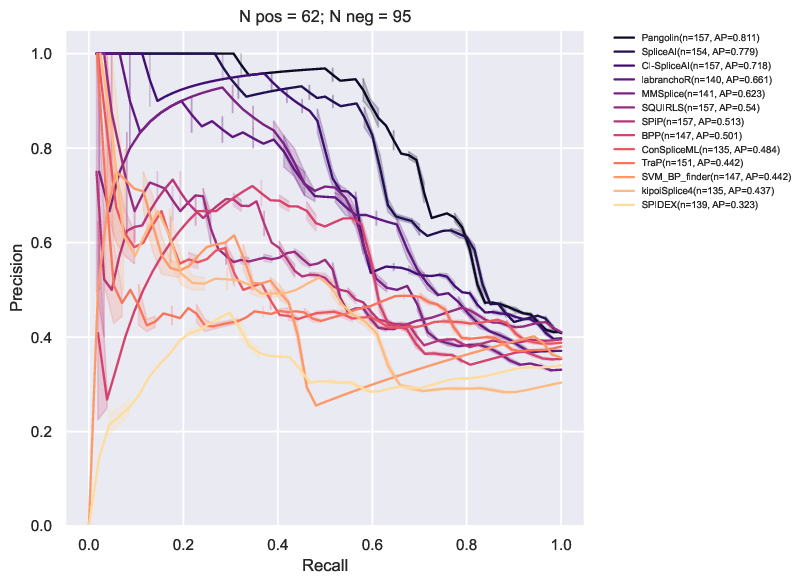

In [254]:
perf="out/out_branchpoint/tools_benchmark/all_types/roc_analysis/roc_pr_all.pdf"
img = WImage(filename=perf, resolution=100)
img

## **2) Variants that trigger pseudoexon inclusion**

This dataset is composed by deep intronic variants that activate the expression of pseudoexons. We analyze four different subsets that activate this sequences by different mechanisms.

### **A) Variants that affect splicing regulatory elements**

This dataset is composed by 76 intronic variants that affect SREs and usually lead to the inclusion of pseudoexons (positive set). Variants from all sources were included here (VazDrago (N=8), PedroBarbosa (N=16), Petersen (N=9), Tubeuf (N=3), Moles_Fernandez (N=1), Keegan (N=15), Jung (N=24)). The neutral dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were proven to not affect splicing. This set comes exclusively from Adamson 20218 (N=123) and 90 variants were randomly selected to balance with the positive set.

For this analysis, we additionally incorporate user-friendly tools such as HEXplorer, ESEfinder and also ESRscores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [255]:
! veta benchmark --out_dir out/out_pe_change_in_sre \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pe_activation/sre_associated/tools_config.txt \
        data/splicing_altering/per_category/pe_activation/sre_associated &> out/log_pe_change_sre.txt 

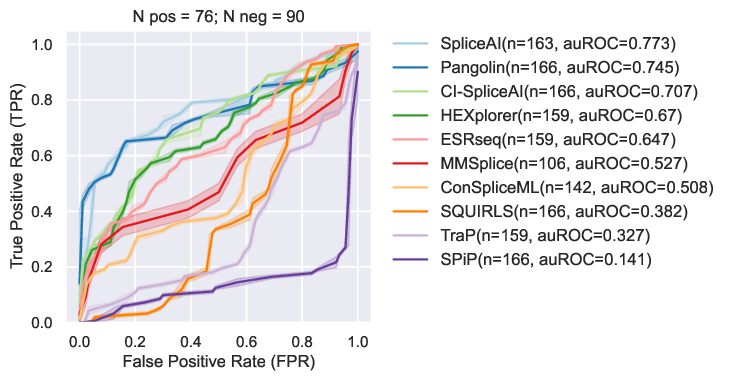

In [256]:
perf="out/out_pe_change_in_sre/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=100)
img

### **B) Variants that are associated with splicing acceptors**

Dataset composed by 89 deep intronic variants that trigger pseudoexon inclusion by the creation of a new splicing acceptor, or by strenghthening a cryptic one, usually affecting a cryptic polypirimidine tract (positive set). Variants from VazDrago (N=13), PedroBarbosa (N=28), Keegan (N=32), Jung (N=13) and Moles-Fernández (N=2) and petersen (N=1) are included here. The neutral dataset (N=110) was not straightforward to generate, since it is hard to gather experimentally validated variants that "create" new splice acceptors and do not lead to any splicing switch. Therefore, to mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 5-mer acceptor C**AG**GT in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 67 variants (same as the positive set that create a new splice acceptor) to serve the control set. Additional 43 variants were retrieved by selecting deep intronic variants that were tested to not affect the splicing outcome that are more than 150bp away from the closest acceptor.

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [257]:
! veta benchmark --out_dir out/out_pe_acceptor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pe_activation/acceptor_associated/tools_config.txt \
    data/splicing_altering/per_category/pe_activation/acceptor_associated &> out/log_pe_acceptor_associated.txt 

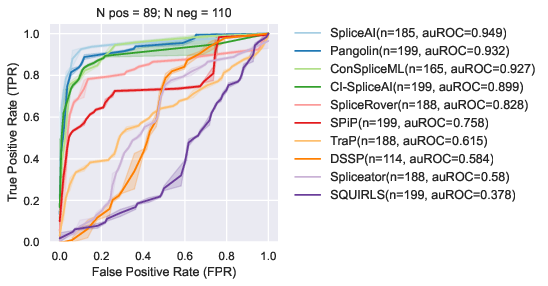

In [258]:
perf="out/out_pe_acceptor_associated/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **C) Variants that create a new splicing donor**

Dataset composed by 171 deep intronic variants that trigger pseudoexon inclusion by the creation of a new splicing donor (positive set). Variants from VazDrago (N=40), PedroBarbosa (N=35), Keegan (N=73), Jung (N=16) and Moles-Fernández (N=7) are included here. A neutral dataset (N=211) was generated as for the acceptor section. To mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 6-mer acceptor G**GT**AAG in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 171 variants to serve the control set, whereas the remaining one (N=40) will serve as controls for an upcoming section (new donor variants that trigger exon elongation).

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [259]:
! veta benchmark --out_dir out/out_pe_new_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pe_activation/new_donor/tools_config.txt \
    data/splicing_altering/per_category/pe_activation/new_donor/ &> out/log_pe_new_donor.txt 

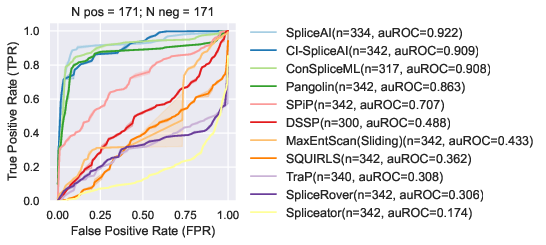

In [260]:
perf="out/out_pe_new_donor/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **D) Variants that affect a near-by cryptic splicing donor**

Dataset composed by 93 deep intronic variants that trigger pseudoexon inclusion by activation of a near-by upstream splicing donor (positive set). Variants from VazDrago (N=13), PedroBarbosa (N=26), Keegan (N=30), Jung (N=22) and Moles-Fernández (N=1) and Petersen (N=1) are included here. A neutral dataset (N=99) was generated by selecting donor-associated at >20bp from the nearest donor. Variants from Adamson (N=19), Cheung (N=19) and Moles-Fernandez (N=61) are presented here.

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [261]:
! veta benchmark --out_dir out/out_pe_donor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pe_activation/donor_associated/tools_config.txt \
    data/splicing_altering/per_category/pe_activation/donor_associated/ &> out/log_pe_donor_associated.txt 

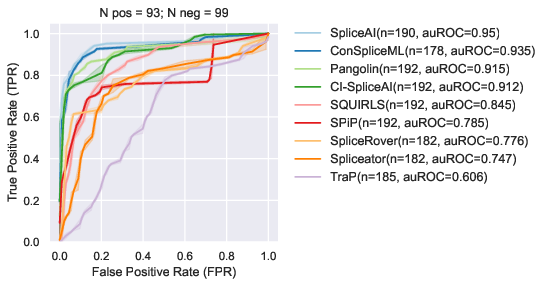

In [262]:
perf="out/out_pe_donor_associated/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

## **2) Variants leading to exon elongation/partial intron retention**

This dataset is composed by intronic variants that trigger elongation of an annotated exon. We analyze four different subsets that lead to this functional outcome.

### **A) Variants that affect splicing regulatory elements**

This subset of variants is interesting, because contains intronic variants that trigger exon elongation, and that in the new extended exon are exonic. It is composed by 29 that probably affect SREs and create the conditions for a downstream donor or upstream upstream acceptor to be used instead (positive set). Most of these variants were detected in Jung (N=26), with few coming from other studies too: Moles-Fernandez (N=1), pbarbosa (N=1) and vazDrago (N=1). The neutral dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were proven to not affect splicing. This set comes exclusively from Adamson 20218 (N=123) and 33 variants were randomly selected to balance with the positive set.

For this analysis, we additionally incorporate user-friendly tools such as HEXplorer, ESEfinder and also ESRscores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [205]:
! veta benchmark --out_dir out/out_elong_change_in_sre \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/exon_elongation/sre_associated/tools_config.txt \
        data/splicing_altering/per_category/exon_elongation/sre_associated &> out/log_elong_change_sre.txt 

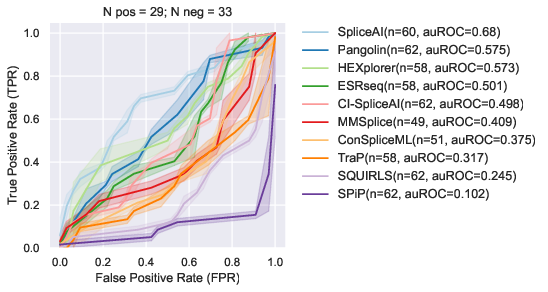

In [206]:
perf="out/out_elong_change_in_sre/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **B) Variants that are associated with splicing acceptors**

Dataset composed by 44 intronic variants that trigger exon elongation by the creation of a new splicing acceptor, or by strenghthening a cryptic one, usually affecting a cryptic polypirimidine tract (positive set). Variants from VazDrago (N=2), PedroBarbosa (N=10), Jung (N=31) and Moles-Fernández (N=1) are included here. The neutral dataset (N=61) was generated based on the proximity of variants to annotated exons located between -3 and -18 and -44 and 150bp upstream of the splice acceptors. Variants from Adamson (N=38), Cheung (N=17) and Moles-Fernandez (N=6) are present here.

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [207]:
! veta benchmark --out_dir out/out_elong_acceptor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/exon_elongation/acceptor_associated/tools_config.txt \
    data/splicing_altering/per_category/exon_elongation/acceptor_associated &> out/log_elong_acceptor_associated.txt 

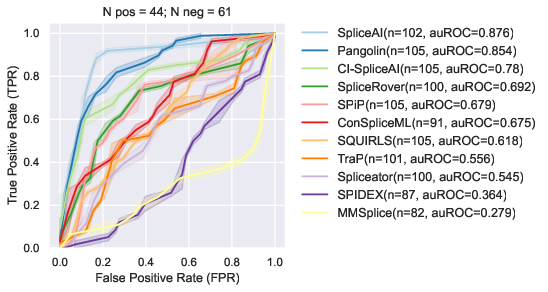

In [208]:
perf="out/out_elong_acceptor_associated/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **C) Variants that create a new splicing donor**

Dataset composed by 39 intronic variants that create a new splice donor and lead to exon elongation/partial intron retention (positive set). Variants from VazDrago (N=2), PedroBarbosa (N=10), Keegan (N=73), Jung (N=25) and Moles-Fernández (N=2) are included here. A neutral dataset (N=40) was generated by randomly selecting 40 variants from the set of 211 gnomAD variants that create a new splice donor motif.

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [209]:
! veta benchmark --out_dir out/out_elong_new_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/exon_elongation/new_donor/tools_config.txt \
    data/splicing_altering/per_category/exon_elongation/new_donor/ &> out/log_elong_new_donor.txt 

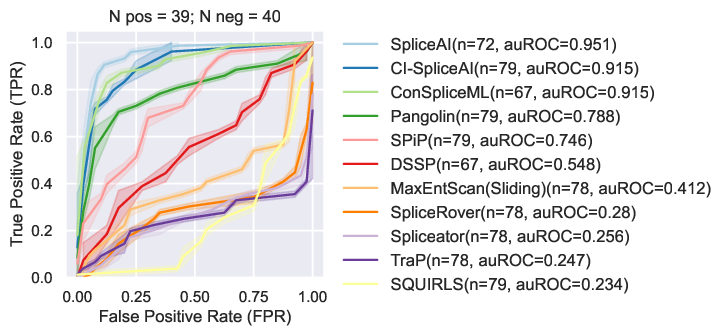

In [210]:
perf="out/out_elong_new_donor/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=100)
img

### **D) Variants that affect a near-by cryptic splicing donor**

Dataset composed by 55 intronic variants that trigger exon elongation by activation of a near-by upstream splicing donor (positive set). Variants from VazDrago (N=13), PedroBarbosa (N=26), Keegan (N=30), Jung (N=22) and Moles-Fernández (N=1) and Petersen (N=1) are included here. A neutral dataset (N=70) was generated by looking at intronic variants located at <20bp from the upstream splice donor that were experimentally tested for no effect on splicing of the upstream exon. Variants from Adamson (N=31) and Cheung (N=39) are included here.

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [211]:
! veta benchmark --out_dir out/out_elong_donor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/exon_elongation/donor_associated/tools_config.txt \
    data/splicing_altering/per_category/exon_elongation/donor_associated/ &> out/log_elong_donor_associated.txt 

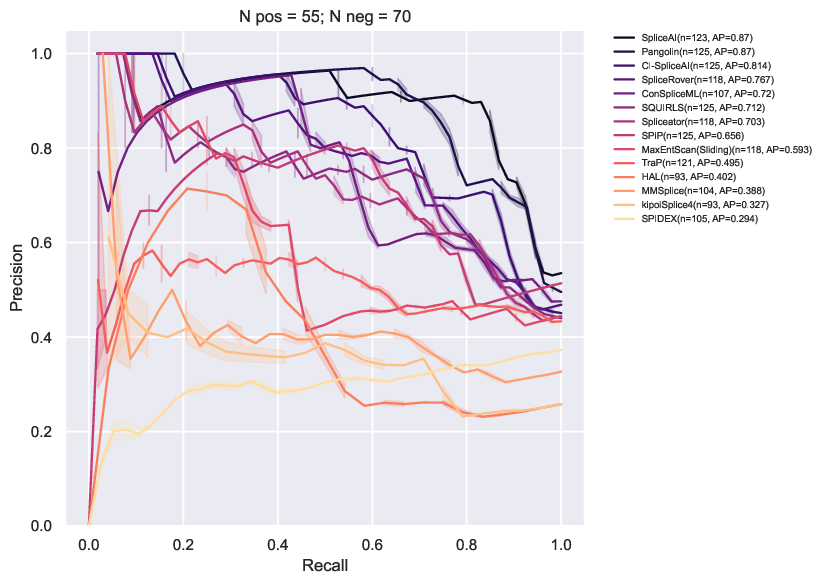

In [212]:
perf="out/out_elong_donor_associated/tools_benchmark/all_types/roc_analysis/roc_pr_all.pdf"
img = WImage(filename=perf, resolution=100)
img

## Old analysis

## Splicing regulatory elements

This dataset is composed by 107 intronic variants that affect SREs and usually lead to the inclusion of pseudoexons (positive set). Variants from all sources were included here (VazDrago (N=9), PedroBarbosa (N=17), Petersen (N=9), Tubeuf (N=3), Moles_Fernandez (N=3), Keegan (N=15), Jung (N=51)). The neutral dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were proven to not affect splicing. This set comes exclusively from Adamson 20218 (N=123).

For this analysis, we additionally incorporate user-friendly tools such as HEXplorer, ESEfinder and also ESRscores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

This dataset is composed by 107 intronic variants that affect SREs and usually lead to the inclusion of pseudoexons (positive set). Variants from all sources were included here (VazDrago (N=9), PedroBarbosa (N=17), Petersen (N=9), Tubeuf (N=3), Moles_Fernandez (N=3), Keegan (N=15), Jung (N=51)). The neutral dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were proven to not affect splicing. This set comes exclusively from Adamson 20218 (N=123).

For this analysis, we additionally incorporate user-friendly tools such as HEXplorer, ESEfinder and also ESRscores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [ ]:
! veta benchmark --out_dir out/out_change_in_sre \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/splicing_regulatory_elements/final/tools_config.txt \
    data/splicing_altering/per_category/splicing_regulatory_elements/final/ &> out/log_change_sre.txt 

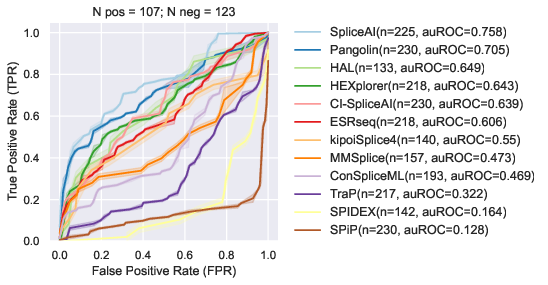

In [41]:
perf="out/out_change_in_sre/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **B) Variants that create new splice acceptor**

Dataset composed by 67 intronic variants that create a new splicing acceptor, and usually activate an exiting cryptic donor site downstream leading to pseudoexon inclusion (positive set). Variants ocurring at one of the two splice site positions, as well as in the first position of the new pseudexon were incorporated in this class. Variants from VazDrago (N=12), PedroBarbosa (N=28), Keegan (N=20), Jung (N=20) and Moles-Fernández (N=3) are included here. The neutral dataset (N=67) was not straightforward to generate, since it is hard to gather experimentally validated variants that "create" new splice sites and do not lead to any splicing switch. Therefore, to mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 5-mer acceptor C**AG**GT in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 67 variants (same as the positive set) to serve the control set.


For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [36]:
! veta benchmark --out_dir out/out_new_acceptor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/new_splice_acceptor/final/tools_config.txt \
    data/splicing_altering/per_category/new_splice_acceptor/final/ &> out/log_new_acceptor.txt 

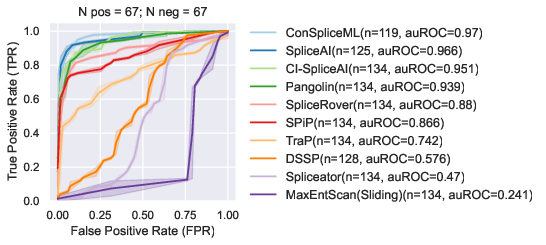

In [42]:
perf="out/out_new_acceptor/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **C) Variants that create new splice donor**

Dataset composed by 211 intronic variants that create a new splicing donor, and usually activate an exiting cryptic acceptor site upstream leading to pseudoexon inclusion (positive set). Variants ocurring at one of the two splice site positions, as well as in the last position of the new pseudexon were incorporated in this class. Variants from VazDrago (N=42), PedroBarbosa (N=46), Keegan (N=73), Jung (N=41) and Moles-Fernández (N=9) are included here. The neutral dataset (N=211) was generated according the principle used in the previous section B, because it is not trivial to gather experimentally validated variants that "create" new splice sites and do not lead to any splicing switch. Therefore, to mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 6-mer acceptor G**GT**AAG in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 211 variants (same as the positive set) to serve the control set.


Just like for new acceptors, we additionally incorporate some deep learning methods that predict splice sites. This includes SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [37]:
! veta benchmark --out_dir out/out_new_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/new_splice_donor/final/tools_config.txt \
    data/splicing_altering/per_category/new_splice_donor/final/ &> out/log_new_donor.txt 

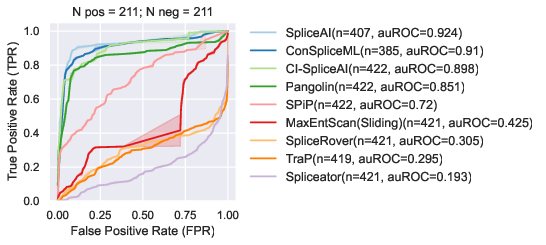

In [43]:
perf="out/out_new_donor/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **D) Variants that affect a near by cryptic splice acceptor**

This dataset is composed by 70 intronic variants that affect an existing cryptic splicing acceptor, usually by strengthening it and leading to pseudoexon activation (positive set). The variants locate between the position -3 to -18 upstream of the cryptic acceptor site, largely overlapping the polypirimide tract. Variants from VazDrago (N=3), PedroBarbosa (N=14), Petersen (N=1), Keegan (N=12) and Jung (N=40) are included here. The neutral dataset (N=103) is composed of experimentally validated variants that occur upstream of an existing acceptor, and did not lead to any splicing change. Most of them occur at -3 to -18bp upstream of the splice site (matching the setup of the positive set), but there are some that locate deeper within introns (outside of the the branchpoint-associated region, -18 to - 44). Variants from Adamson (N=51), Cheung (N=16) and Moles-Fernández (N=36) compose this neutral set.

For this analyis, we additionally incorporate IntSplice2, that predicts variation specifically at intronic positions upstream of splice acceptors, as well as SpliceRover and Spliceator, two deep learning methods that are able to predict splice sites for multiple positions in a single input sequence (variants affecting positions in the neighbourhood of (cryptic) splice sites should affect the model outcome). DSSP (used in the previous sections) does not fit here, since it returns predictions for fixed locations. The steps to generate VCFs with the variant effect scores for Spliceator and SpliceRover can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [38]:
! veta benchmark --out_dir out/out_strength_acceptor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/acceptor_associated/final/tools_config.txt \
    data/splicing_altering/per_category/acceptor_associated/final/ &> out/log_strength_acceptor.txt 

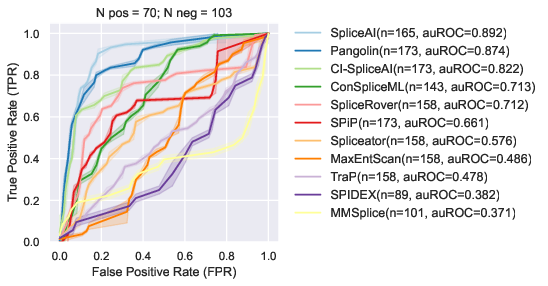

In [44]:
perf="out/out_strength_acceptor/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **E) Variants that affect a near by cryptic splice donor**

This dataset is composed by 148 intronic variants that affect an existing cryptic splicing donor, usually by strengthening it and leading to pseudoexon activation (positive set). Most of the variants locate between the position +3 to + 10 downstream of the cryptic donor site. Variants from VazDrago (N=15), PedroBarbosa (N=32), Petersen (N=1), Moles-Fernández (N=2), Keegan (N=30) Jung (N=68) are included here. The neutral dataset (N=111) is composed of experimentally validated variants that occur downstream of an existing donor, and did not lead to any splicing change. Variants from Adamson (N=50), Moles-Fernández (N=61) compose this neutral set.

For this analyis, we additionally incorporate SpliceRover and Spliceator, just as we did for the previous section. Again, the steps to generate VCFs with the variant effect scores for Spliceator and SpliceRover can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [39]:
! veta benchmark --out_dir out/out_strength_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/donor_associated/final/tools_config.txt \
    data/splicing_altering/per_category/donor_associated/final/ &> out/log_strength_donor.txt 

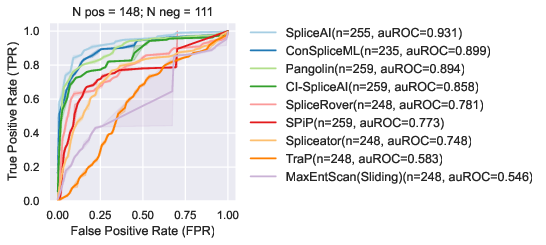

In [45]:
perf="out/out_strength_donor/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **F) Variants that affect the branchpoint signal**

This dataset is composed by 61 intronic variants that affect the branchpoint signal (located -18 to -44bp upstream of an annotated splicing acceptor), usually leading to intron retention and/or exon skipping. There are few exceptions that actually do the opposite, by creating a new branchpoint and leading to partial intron retention and/or pseudoexon activations. Variants from Jung (N=48), PedroBarbosa (N=9), Petersen (N=1) and Keegan (N=3) are included here. The neutral dataset (N=96) is composed of experimentally validated variants that between the -18 and -44 bp upstream of existing splicing acceptors, and did not lead to any splicing change. Variants from Adamson (N=59), Moles-Fernández (N=2) and Cheung (N=35) compose this neutral set.

For this analyis, we additionally incorporate branchpoint-specific tools such as BPP, labranchoR and SVM BP finder, as well as IntSplice2 that is targeted to make predictions in these regions. The steps to generate VCFs with the variant effect scores for BPP and SVM BP finder can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors). labranchoR was run within the kipoi framework, and VETA has internal functions to automatically process its ouput.

In [40]:
! veta benchmark --out_dir out/out_branchpoint \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --do_threshold_analysis \
    --config data/splicing_altering/per_category/branchpoint_associated/final/tools_config.txt \
    data/splicing_altering/per_category/branchpoint_associated/final/ &> out/log_branchpoint.txt 

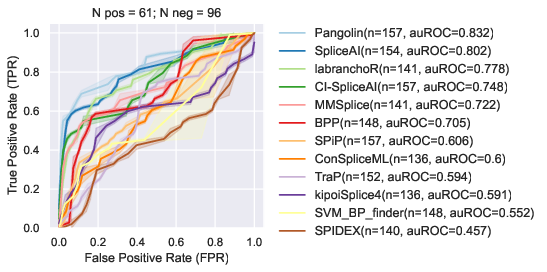

In [49]:
perf="out/out_branchpoint/tools_benchmark/all_types/roc_analysis/roc_all.pdf"
img = WImage(filename=perf, resolution=75)
img